# Tutorial. The Chebyshev interpolation

Spectral methods are a class of spatial discretisation methods for differential equations in which the approximation of the solution $u$ of the problem is based an expansion in terms of so-called *trial functions* $\{\phi_k\}_{k=0,\dots,N-1}$,
$$
u(x)\approx\sum_{k=0}^{N-1}\tilde{u}_k\phi_k(x),
$$
the coefficients of the expansion being noted $\tilde{u}_k$, $k=0,\dots,N-1$.

The choice of the trial function is dictated by the practical and computational efficiency of of the numerical method, and it has to meet the following requirements:
* *Convergence:* the approximation should converge rapidly to the solution $u$ as $N$ tends to $+\infty$,
* *Transformation:* the computation of the coefficients $\tilde{u}_k$ from the values of $u$ and the reconstruction of the function values at given nodes from the set of coefficients should be computationally fast,
* *Differentiation:* given the expansion coefficients of a function, it should be easy to determine the set of coefficients associated with an approximation of a spatial derivative of the function.

For non-periodic boundary problems, algebraic polynomial functions are used, in the form of orthogonal (with respect to a weighted $L^2$-scalar product) systems of polynomials functions over the interval $(-1,1)$.

The present notebook aims at investigating some computational and numerical aspects of the [Lagrange interpolating polynomial](https://en.wikipedia.org/wiki/Lagrange_polynomial) of a function at the so-called Chebyshev-Gauss-Lobatto points and its representation in the basis of [Chebyshev polynomials of the first kind](https://en.wikipedia.org/wiki/Chebyshev_polynomials). 

The <tt>numpy</tt>, <tt>scipy</tt> and <tt>matplotlib</tt> packages will be needed.

In [15]:
import numpy as np
import scipy as scp

# To draw matplotlib plots within this notebook.
%matplotlib inline
import matplotlib.pyplot as plt
from python_code.nord_cmap import * 
from tqdm import tqdm
from typing import Callable, Iterable

## Exercise 1. The Lagrange interpolation at the Chebyshev-Gauss-Lobatto points using the Chebyshev basis.

Given a non-zero integer $N$, the Chebyshev interpolation of a given function $u$ over the interval $[-1,1]$ consists in the construction of the Lagrange interpolating polynomial of degree $N$ at the Chebyshev-Gauss-Lobatto point, that is the polynomial function $I_Nu$ of degree $N$ satisfying the conditions
$$
I_Nu(x_j)=u(x_j),\ j=0,\dots,N,
$$
at the Chebyshev-Gauss-Lobatto quadrature nodes
$$
x_j=\cos\left(\frac{\pi j}{N}\right),\ j=0,\dots,N.
$$

### The Chebyshev basis
When used in collocation spectral methods, this interpolation polynomial is written in the basis formed by the Chebyshev polynomials of the first kind, which is orthogonal with respect to the weighted $L^2_w((-1,1),\mathbb{R})$-scalar product, with weight $w(x)=\frac{1}{\sqrt{1-x^2}}$. They are the unique polynomials satisfying
$$
\forall k\in\mathbb{N},\ \forall\theta\in\mathbb{R},\ T_k(\cos(\theta))=\cos(k\theta).
$$
In practice, they can be obtained from the recurrence relation
$$
\begin{align*}
&T_0(x) = 1,\\
&T_1(x) = x,\\
&\forall k\in\mathbb{N}^*,\ T_{k+1}(x) = 2xT_{k}(x)-T_{k-1}(x).
\end{align*}
$$

Note that the Chebyshev-Gauss-Lobatto quadrature nodes introduced above are the extrema of $T_N$ on the interval $[-1,1]$.

**Question.** Write a function computing the coefficients in the canonical basis of $\mathbb{P}_N$ of the $N+1$ first Chebyshev polynomials, the non-zero integer $N$ being given. The coefficients will be returned in a two-dimensional array.

In [16]:
def compute_Chebyshev_coefficients(N : int) -> Callable : 
    """
    compute_Chebyshev_coefficients compute the the coefficients in the canonical basis of 
    P_N of the N + 1 first Chebyshev polynomial

    Parameters
    ----------
    N : int
        _description_

    Returns
    -------
    Callable
        array of coefficients
    """
    array_coeff = np.zeros(shape = (N+1, N + 1))
   
    array_coeff[0][0] = 1
    array_coeff[1][1] = 1

    for k in range(2, N + 1) : 
        
        array_coeff[k] = 2 * np.insert(array_coeff[k-1,:-1],0,0) - array_coeff[k-2]
        
    return array_coeff

In [17]:
coeffs = compute_Chebyshev_coefficients(5)

In [18]:
coeffs

array([[  1.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   1.,   0.,   0.,   0.,   0.],
       [ -1.,   0.,   2.,   0.,   0.,   0.],
       [  0.,  -3.,   0.,   4.,   0.,   0.],
       [  1.,   0.,  -8.,   0.,   8.,   0.],
       [  0.,   5.,   0., -20.,   0.,  16.]])

**Question.** Using the previous function and the `polyval` function in the `polynomial.polynomial` library of <tt>numpy</tt>, plot the graphs of the first six Chebyshev polynomial functions over $[-1,1]$.

/tmp/ipykernel_3604/1572398498.py:9: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-o" (-> linestyle='-'). The keyword argument will take precedence.
  ax.plot(x, polyval(x,coeffs[N]), '-o', lw = .5, markersize = 1, linestyle = 'dashed', color = color[N], label = f'$N = {N}$')


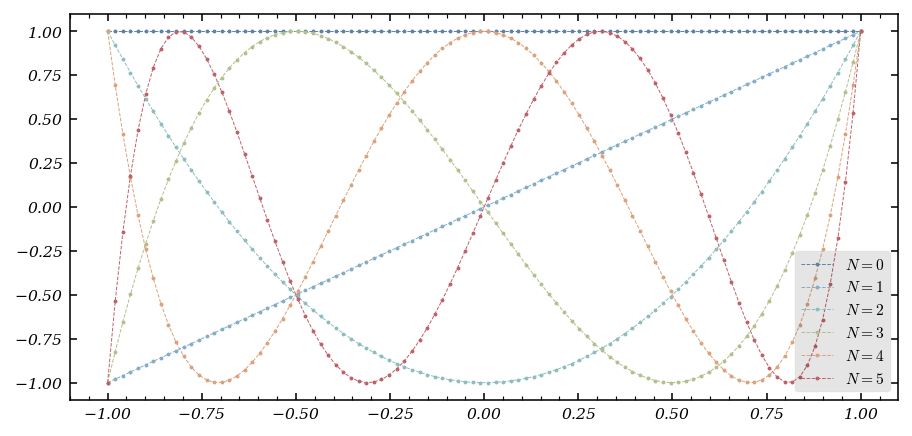

In [19]:
from numpy.polynomial.polynomial import polyval

fig, ax = plt.subplots()
color = color_list(6)
x = np.linspace(-1,1, 100)

for N in range(6):
    
    ax.plot(x, polyval(x,coeffs[N]), '-o', lw = .5, markersize = 1, linestyle = 'dashed', color = color[N], label = f'$N = {N}$')

ax.legend()

### The Chebyshev representation of the Lagrange interpolation polynomial at Chebyshev nodes.

We now consider the Lagrange interpolation of a function $u$ defined on the interval $[-1,1]$ (the procedure can be generalised to a function defined on any compact domain $[a,b]$ through translation and scaling).

The interpolation is done at the Chebyshev-Gauss-Lobatto points previously introduced, and the interpolation polynomial is written in the Chebyshev basis:
$$
I_Nu(x)=\sum_{k=0}^N\tilde{u}_kT_k(x).
$$

**Question.** Provide an explicit form for the polynomial expansion coefficients $\tilde{u}_k$ and show that they can be computed using the type-I [discrete cosine transform](https://en.wikipedia.org/wiki/Discrete_cosine_transform), a Fourier-related transform similar to the discrete Fourier transform.

**Answer.**

In this case, the discrete Chebyshev transform based on CGL points takes the form 

$k = 0, \dots, N \hspace{1cm}$ 

\begin{align*}
    \tilde u_k &= \frac{1}{\gamma_k} \sum_{j=0}^Nu(x_j)T_k(x_j)w_j\\
    &= \frac{2}{\pi \bar c_k}\sum_{j=0}^Nu(x_j)\cos\Big(k\arccos\Big(\frac{\pi j}{N}\Big)\Big)\frac{\pi}{N \bar c_j}\\
    &= \frac{2}{N\bar c_k}\sum_{j=0}^N u(x_j)\frac{1}{\bar c_j}\cos\Big(\frac{kj}{N}\Big)

\end{align*}


Discrete Chebyshev transform based on the Chebyshev-Gauss-Lobatto points $x_j = \cos(\frac{\pi}{N}j)$, $j = 0, \dots, N$ in $[-1,1]$.
$$\tilde u_k = \frac{2}{N \bar c_k} \sum_{j=0}^{N} u(x_j) \frac{1}{\bar c_j} \cos(\frac{k \pi}{N} j)
$$
where $\bar c_j  = \begin{cases}
   2 \hspace{.3cm}\text{ if } j = 0 \text{ or } N \\
    1 \hspace{.3cm}\text{ if } j = 1, ..., N-1 
\end{cases}$

**Question.** Write a function computing the expansion coefficients of the interpolant $I_Nu$ of a function $u$, the function and the integer $N$ being given, using the `dct` function of the `fft` library of <tt>scipy</tt> (see the [documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.fft.dct.html) and note the normalisation used in the definition of the DCT-I implemented).

In [20]:
from scipy import fft

In [162]:
def compute_dct_coeff(N : int, u : Callable) :

    """
    compute_Chebyshev_coeff _summary_

    Parameters
    ----------
    N : int
        _description_
    u : Callable
        _description_
    """     
    x = np.cos(np.arange(N+1)/N * np.pi)
    u_ = u(x)
    coeffs = fft.dct(u_,  type = 1, norm = 'forward')  
    coeffs[1:-1] = 2 * coeffs[1:-1]
    
    return coeffs
    
    

**Question.** Write a function which evaluates the interpolant $I_Nu$ of a function $u$ at a given set of points, the set of coefficients of the interpolant being given.

In [163]:
def interpolant_chebyshev(set_coefficients : Iterable, set_points : Iterable) : 
    
    """
    interpolant_chebyshev _summary_

    Parameters
    ----------
    set_coefficients : _type_
        _description_
    """    
    coeffs_chebyshev = compute_Chebyshev_coefficients(len(set_coefficients))
    poly = 0
    
    for k in range(len(set_coefficients)) : 
        
        poly +=  polyval(set_points, coeffs_chebyshev[k]) * set_coefficients[k]
            
    return poly
    

**Question.** Use the written functions to plot and compare the graphs of the following functions and their respective interpolants over $[-1,1]$, for several values of $N$,

* $u(x) = \cos((x + 1)\pi) + \sin(2(x + 1)\pi)$,
* $u(x) = \mathbb{1}_{\left[-\frac{1}{2},\frac{1}{2}\right]}(x)$,
* $u(x) = \dfrac{1}{1+25x^2}$.

For which of these the Chebyshev interpolant seems to provide a relevant approximation of the function? Is the [Gibbs phenomenon](https://en.wikipedia.org/wiki/Gibbs_phenomenon) observed?

In [292]:
def u_3(x) : return 1/(1 + 25 * x ** 2)
def u_2(x) : 
    
    mask =  np.abs(x) < 1 / 2
    a = np.zeros_like(x)
    a[mask] = 1
    return a 
def u_1(x) : return np.cos((x+1) * np.pi) + np.sin(2 * (x + 1) * np.pi)

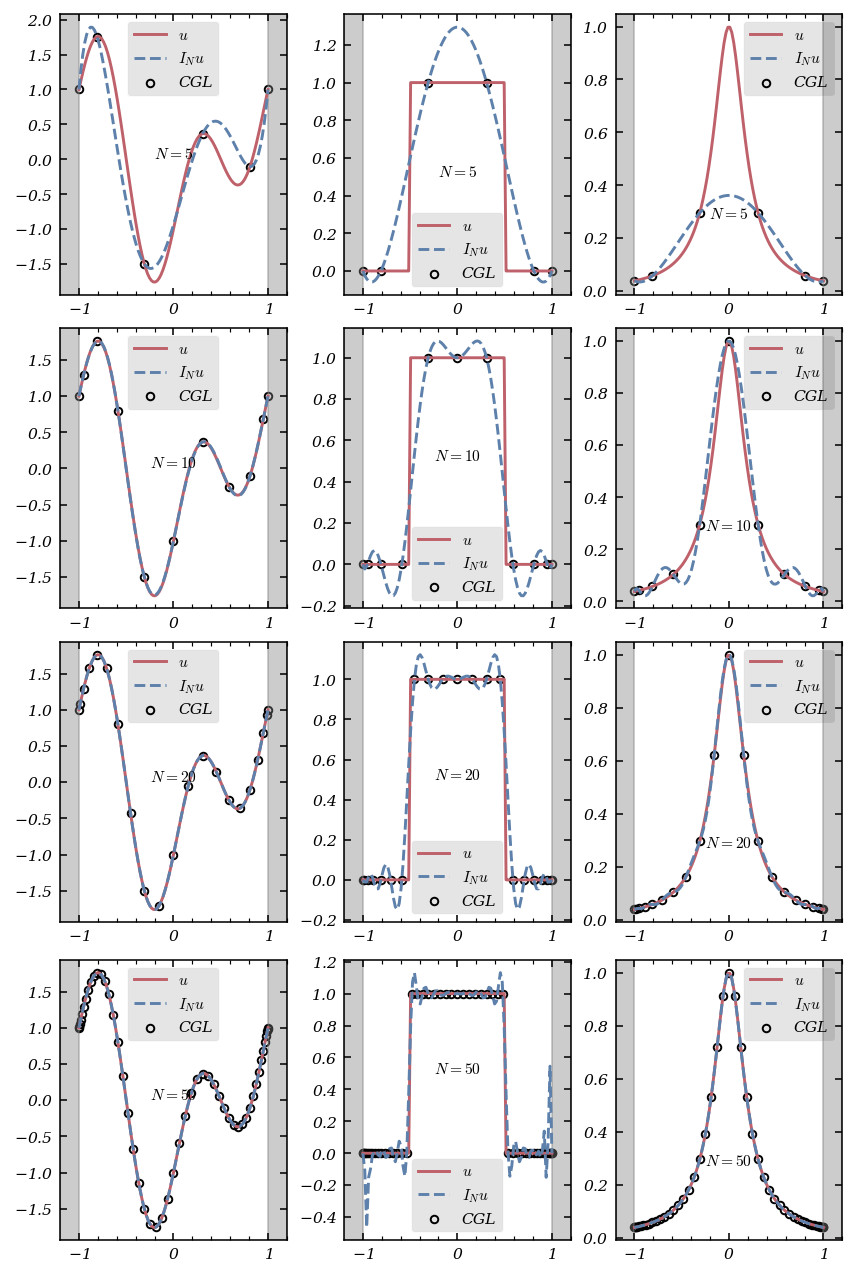

In [293]:
fig, ax = plt.subplots(4,3, figsize = (6,9))
x = np.linspace(-1,1,100)
N = [5, 10, 20, 50]
func = [u_1, u_2, u_3]

color = color_list(2)

for k in range(len(N)):
    for j in range(3) : 
        
        ax[k,j].plot(x,func[j](x), color = color[1], label = '$u$')
        ax[k,j].plot(x, interpolant_chebyshev(compute_dct_coeff(N[k], func[j]), x),'--', color = color[0], label = '$I_N u $')
        CGL = np.cos(np.arange(N[k] + 1)/N[k] * np.pi)
        ax[k,j].scatter(CGL, func[j](CGL), s = 15, fc = (0,0,0,0), ec = 'k',  label = 'CGL')
        
        ax[k,j].set_xlim(-1.2, 1.2)
        ax[k,j].axvspan(-1.2,-1, color = 'grey', alpha = .4)
        ax[k,j].axvspan(1,1.2, color = 'grey', alpha = .4)
        
        ax[k,j].text(0, np.mean(func[j](x)), f"$N = {N[k]}$", ha = 'center')
        ax[k,j].legend()

**Answer.**

Relevant for $u(x) = \cos((x + 1)\pi) + \sin(2(x + 1)\pi)$ and $u(x) = \dfrac{1}{1+25x^2}$. For 
$u(x) = \mathbb{1}_{\left[-\frac{1}{2},\frac{1}{2}\right]}(x)$, there is Gibbs phenomenon

## Exercise 2. The Chebyshev interpolation derivative.

The *Chebyshev interpolation derivative* of a function $u$ is defined as the derivative of the interpolant $I_nu$, that is
$$
\mathcal{D}_Nu=(I_Nu)',
$$
and, using the representation in the Chebyshev basis previously used, one can write
$$
\mathcal{D}_Nu(x)= \sum_{k=0}^N\tilde{u}_k{T_k}'(x).
$$

**Question.** Show that
$$
\forall x\in(-1,1),\ (I_Nu)'(x) = \frac{1}{\sqrt{1-x^2}}\sum_{k=0}^Nk\tilde{u}_k\sin(k\arccos(x)),
$$
and, using l'Hôpital's rule, that
$$
(I_Nu)'(1)=\sum_{k=0}^Nk^2\tilde{u}_k,\\
(I_Nu)'(-1)=\sum_{k=0}^N(-1)^{k+1}k^2\tilde{u}_k.
$$

**Answer.**

We recall that the type-I [discrete sine transform](https://en.wikipedia.org/wiki/Discrete_sine_transform) of the sequence $\{v_i\}_{i=0,\dots,M}$ is the sequence $\{\tilde{v}_m\}_{m=0,\dots,M}$ defined by
$$
\forall m\in\{0,\dots,M\},\ \tilde{v}_m=\sum_{i=0}^{M}v_i\sin\left(\frac{\pi}{M+2}(i+1)(m+1)\right).
$$

**Question.** Write a function which computes the values $(I_Nu)'(x_j)$, $j=0,\dots,N$, the coefficients of $I_Nu$ being given, using the `idst` function of the `fft` library of <tt>scipy</tt> (see the [documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.fft.idst.html)) returning the inverse [discrete sine transform](https://en.wikipedia.org/wiki/Discrete_sine_transform) of a sequence.

**Answer.**

In [227]:
coeffs_chebyshev = compute_Chebyshev_coefficients(5)
coeffs_der = (coeffs_chebyshev[1:] * np.arange(len(coeffs_chebyshev)))
coeffs_der = coeffs_der[:,1:]

coeffs_der, coeffs_chebyshev

(array([[  1.,   0.,   0.,   0.,   0.],
        [  0.,   4.,   0.,   0.,   0.],
        [ -3.,   0.,  12.,   0.,   0.],
        [  0., -16.,   0.,  32.,   0.],
        [  5.,   0., -60.,   0.,  80.]]),
 array([[  1.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   1.,   0.,   0.,   0.,   0.],
        [ -1.,   0.,   2.,   0.,   0.,   0.],
        [  0.,  -3.,   0.,   4.,   0.,   0.],
        [  1.,   0.,  -8.,   0.,   8.,   0.],
        [  0.,   5.,   0., -20.,   0.,  16.]]))

In [283]:
def der_interpolant(coeff_interpolant, nodes) : 
        
    coef = 1/np.sqrt(1 - nodes**2) 
    k = np.arange(len(coeff_interpolant)) 
    interpol = np.empty_like(nodes)
    
    for j in range(len(nodes)) : 
    
        interpol[j] = np.sum(k * coeff_interpolant * np.sin(k *  np.arccos(nodes[j])))    
            
    return coef * interpol

**Question.** Compare the graphs of the derivatives the following functions with the values at the interpolation nodes of their respective Chebyshev interpolation derivatives, for several values of $N$,

* $u(x) = \cos((x + 1)\pi) + \sin(2(x + 1)\pi)$,
* $u(x) = \begin{cases}1 & \text{if } -1 \leq x < 0 \\-1 & \text{if } 0 \leq x \leq 1\end{cases}$,
* $u(x) = \dfrac{1}{1+25x^2}$.

In [284]:
def u_3(x) : return 1/(1 + 25 * x ** 2)
def u_2(x) : 
    mask =  np.abs(x) <= 0
    a = np.ones_like(x)
    a[mask] = -1
    
    return a 

def u_1(x) : return np.cos((x+1) * np.pi) + np.sin(2 * (x + 1) * np.pi)

In [285]:
def u_3p(x) : return -(50 * x) / (1 + 25 * x ** 2)**2
def u_2p(x) : 
    return np.zeros_like(x)

def u_1p(x) : return - np.pi * np.sin((x+1) * np.pi) + 2 * np.pi * np.cos(2 * (x + 1) * np.pi)

/tmp/ipykernel_3604/1403641924.py:3: RuntimeWarning: divide by zero encountered in divide
  coef = 1/np.sqrt(1 - nodes**2)
/tmp/ipykernel_3604/1403641924.py:11: RuntimeWarning: invalid value encountered in multiply
  return coef * interpol


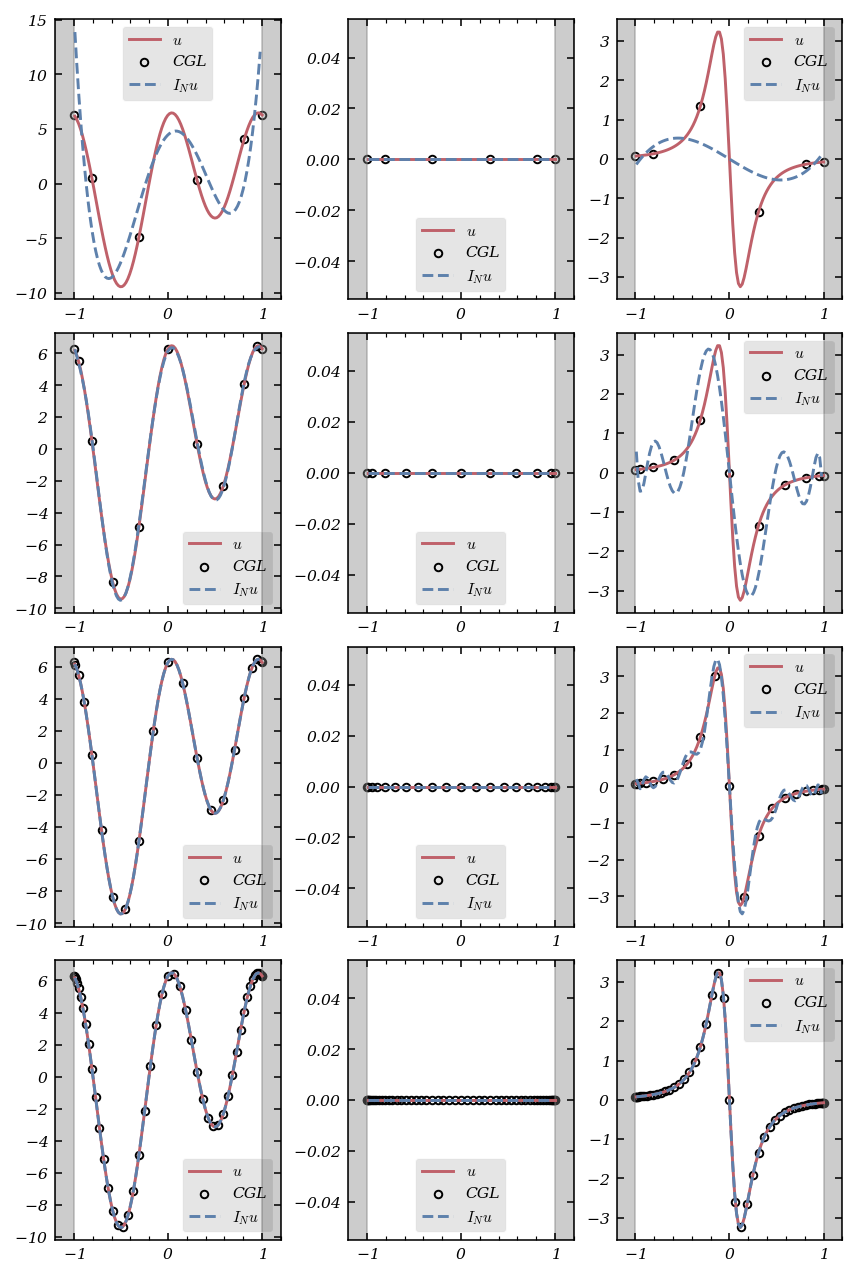

In [290]:
fig, ax = plt.subplots(4,3, figsize = (6,9))
x = np.linspace(-.99,1,100)
N = [5, 10, 20, 50]
func = [u_1, u_2, u_3]
funcp =[u_1p, u_2p, u_3p]
color = color_list(2)

for k in range(len(N)):
    for j in range(3) : 
        
        ax[k,j].plot(x,funcp[j](x), color = color[1], label = '$u$')
        
        CGL = np.cos(np.arange(N[k] + 1)/N[k] * np.pi)
        ax[k,j].scatter(CGL, funcp[j](CGL), s = 15, fc = (0,0,0,0), ec = 'k',  label = 'CGL')
        ax[k,j].plot(x, der_interpolant(compute_dct_coeff(N[k], func[j]), x),'--', color = color[0], label = '$I_N u $')

        ax[k,j].set_xlim(-1.2, 1.2)
        ax[k,j].axvspan(-1.2,-1, color = 'grey', alpha = .4)
        ax[k,j].axvspan(1,1.2, color = 'grey', alpha = .4)
        ax[k,j].legend()

## Exercise 3. Interpolation at equidistant nodes and the Runge phenomenon.

In this exercise, the use of the [Chebyshev nodes](https://en.wikipedia.org/wiki/Chebyshev_nodes) for the Lagrange interpolation of a function is motivated by observing a problem occuring with evenly spaced nodes: the so called [Runge phenomenon](https://en.wikipedia.org/wiki/Runge%27s_phenomenon).

Consider the approximation of the function $u(x)=\frac{1}{1 + 25x^2}$ over the interval $[-1,1]$ by its Lagrange interpolation polynomial associated with the equidistant nodes
$$
x_j=-1+\frac{2j}{N},\ j=0,\dots,N,
$$
where $N$ is a non-zero natural integer.

If $N$ is not large, the representation of such a polynomial in the canonical basis of $\mathbb{P}_N$ can be computed using the `lagrange` function in the `interpolate` library of <tt>scipy</tt> (see the [documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.lagrange.html)).

**Question.** Compare the graphs over the interval $[-1,1]$ of the function $u$ and of its interpolation polynomial $I_Nu$ at equidistributed nodes for several values of $N$.

In [297]:
from scipy.interpolate import lagrange

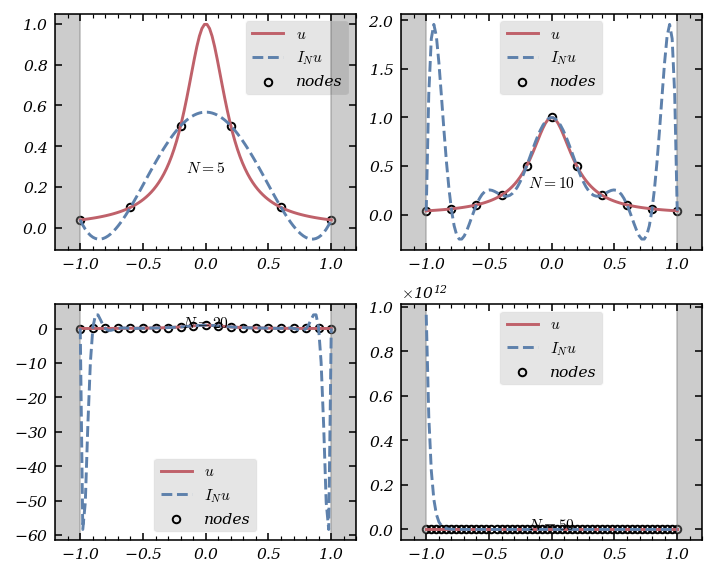

In [304]:

fig, axes = plt.subplots(2,2, figsize = (5,4))
x = np.linspace(-1,1,100)
N = [5, 10, 20, 50]
color = color_list(2)

for k, ax in enumerate(axes.flat) :
        
        points = -1 + 2 * np.arange(N[k] + 1)/N[k]
        ax.plot(x,u_3(x), color = color[1], label = '$u$')
        ax.plot(x, lagrange(points, u_3(points))(x),'--', color = color[0], label = '$I_N u $')

        ax.scatter(points, u_3(points), s = 15, fc = (0,0,0,0), ec = 'k',  label = 'nodes')

        ax.set_xlim(-1.2, 1.2)
        ax.axvspan(-1.2,-1, color = 'grey', alpha = .4)
        ax.axvspan(1,1.2, color = 'grey', alpha = .4)

        ax.text(0, np.mean(u_3(x)), f"$N = {N[k]}$", ha = 'center')
        ax.legend()

**Question.** What happens when the interpolant degree $N$ is increased? Conjecture on the convergence of the sequence of interpolation polynomials of the function and conclude on the adequacy of the choice of evenly spaced nodes for Lagrange interpolation.

**Answer.**

**Question.** Compare the graphs over the interval $[-1,1]$ of the function $u$ and of its interpolation polynomial $I_Nu$ at the Chebyshev nodes 
$$
x_j=\cos\left(\frac{2j+1}{2(N+1)}\,\pi\right),\ j=0,\dots,N,
$$
for several values of $N$. Conclude.

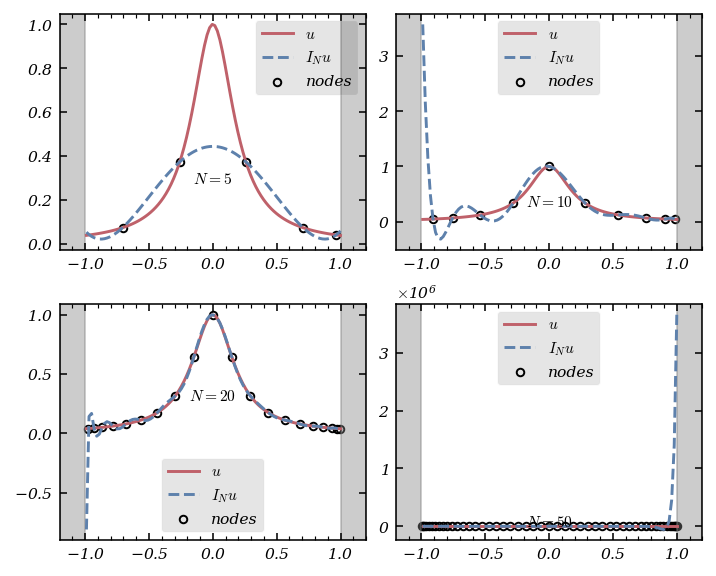

In [307]:

fig, axes = plt.subplots(2,2, figsize = (5,4))
x = np.linspace(-.99,1,100)
N = [5, 10, 20, 50]
color = color_list(2)

for k, ax in enumerate(axes.flat) :
        
        points = np.cos((2 * np.arange(N[k]) +1) / (2 * (N[k] + 1)) * np.pi)
        ax.plot(x,u_3(x), color = color[1], label = '$u$')
        ax.plot(x, lagrange(points, u_3(points))(x),'--', color = color[0], label = '$I_N u $')

        ax.scatter(points, u_3(points), s = 15, fc = (0,0,0,0), ec = 'k',  label = 'nodes')

        ax.set_xlim(-1.2, 1.2)
        ax.axvspan(-1.2,-1, color = 'grey', alpha = .4)
        ax.axvspan(1,1.2, color = 'grey', alpha = .4)

        ax.text(0, np.mean(u_3(x)), f"$N = {N[k]}$", ha = 'center')
        ax.legend()

**Answer.**